# Sentiment Analysis of Twitter Posts

<!-- Notebook name goes here -->
<center><b>Notebook: MultiNaive Bayes Model, Error Analysis, and Tuning</b></center>
<br>

**By**: Stephen Borja, Justin Ching, Erin Chua, and Zhean Ganituen.

**Dataset**: Hussein, S. (2021). Twitter Sentiments Dataset [Dataset]. Mendeley. https://doi.org/10.17632/Z9ZW7NT5H2.1

**Motivation**: Every minute, social media users generate a large influx of textual data on live events. Performing sentiment analysis on this data provides a real-time view of public perception, enabling quick insights into the general population’s opinions and reactions.

**Goal**: By the end of the project, our goal is to create and compare supervised learning algorithms for sentiment analysis.


# **1. Project Set-up**


In [7]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    cross_val_predict,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath("../lib"))
from bag_of_words import BagOfWordsModel

# **2. Data Set-up**


In [2]:
import IPython.core.page
import builtins
from IPython.utils.capture import capture_output

pager = IPython.core.page.page
helper = builtins.help

IPython.core.page.page = lambda *args, **kwargs: None
builtins.help = lambda *args, **kwargs: None

try:
    with capture_output():
        %run data.ipynb
finally:
    IPython.core.page.page = pager
    builtins.help = helper

print("Data Setup is DONE")

# Tests
assert X.shape == (162_801, 29318), "Feature matrix shape is wrong; expected (162_801, 29318)"
assert y.shape == (162_801,), "Labels shape is wrong; expected (162_801,)"

assert X_train.shape == (113_960, 29_318), "Train shape is wrong; expected (113_960, 2)"
assert X_test.shape == (48_841, 29_318), "Test shape is wrong; expected (48_841, 2)"

assert y_train.shape == (113_960,), "Train labels shape is wrong; expected (113_960,)"
assert y_test.shape == (48_841,), "Test labels shape is wrong; expected (48_841,)"

print("All tests passed.")

Data Setup is DONE
All tests passed.


# **3. Model Selection**


# **4. Training the model**


In [3]:
model = MultinomialNB(alpha=1.0)  # HYPERPARAMETER ALPHA

In [4]:
model.fit(X_train, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


In [5]:
model.score(X_test, y_test)

0.7288548555516882

In [15]:
param_grid = {"alpha": [0.01, 0.1, 0.5, 1, 5, 10]}
model = MultinomialNB()

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(model, param_grid, cv=kf, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_["alpha"])
print("Best CV accuracy:", grid.best_score_)

best_model = grid.best_estimator_

Best alpha: 1
Best CV accuracy: 0.7231221481221481


In [17]:
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7288548555516882

In [ ]:
best_model.fit(Xb_train, yb_train)

yb_pred = best_model.predict(Xb_test)

# **5. Evaluate Performance**

ill edit this


# **6. Error Analysis**


In [ ]:
y_true = y_test
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.7289
Precision: 0.7340
Recall:    0.7289
F1 Score:  0.7303


: 

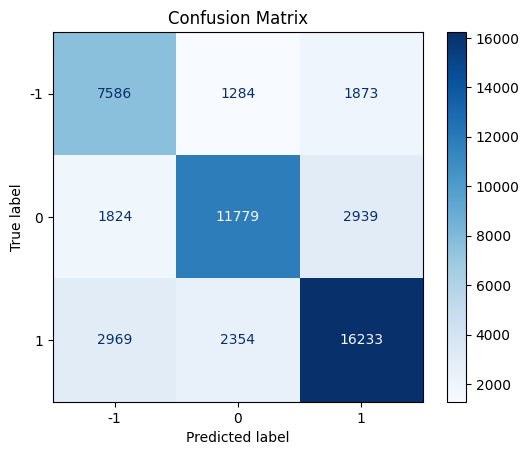

: 

In [ ]:
cm = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, cmap="Blues", display_labels=[-1, 0, 1]
)
plt.title("Confusion Matrix")
plt.show()

# **7. Data Balancing**


Did this in data notebook


# **7. Model Tuning**

do we still gotta do dis brah


# Further Evaluation
